In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Optional for nicer plots
sns.set(style='whitegrid')


In [5]:
# Load first 500,000 rows
df = pd.read_csv("../data/complaints.csv", nrows=500000, low_memory=False)

print(f"Loaded sample shape: {df.shape}")
df.sample(3)

#Due to resource constraints, a 500,000-row random sample of the full dataset was used for EDA and preprocessing. This sample is representative and sufficient for our analysis and prototyping

Loaded sample shape: (500000, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
413036,2025-05-22,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MA,011XX,NaN,NaN,Web,2025-05-22,In progress,Yes,NaN,13668186
41639,2025-06-18,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,NaN,NaN,Experian Information Solutions Inc.,MD,20678,NaN,NaN,Web,2025-06-18,In progress,Yes,NaN,14161648
36461,2025-06-18,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",IL,60484,NaN,NaN,Web,2025-06-18,In progress,Yes,NaN,14155622


In [6]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

# Show top raw products
df['product'].value_counts().head(10)


product
Credit reporting or other personal consumer reports        448273
Debt collection                                             26032
Credit card                                                  8532
Checking or savings account                                  6083
Money transfer, virtual currency, or money service           2961
Mortgage                                                     2105
Student loan                                                 2093
Vehicle loan or lease                                        1850
Payday loan, title loan, personal loan, or advance loan      1104
Prepaid card                                                  558
Name: count, dtype: int64

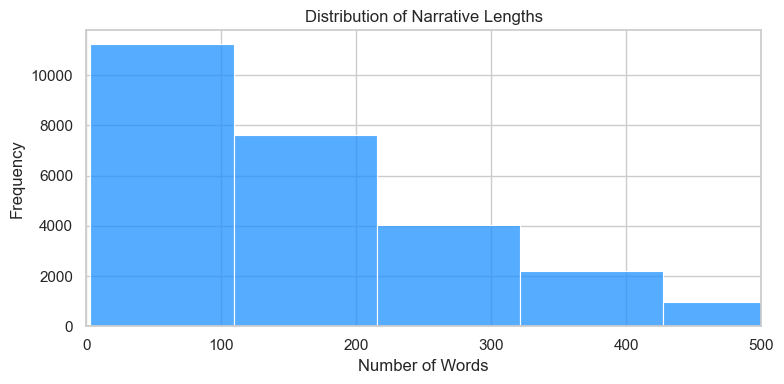

count    26898.000000
mean       182.980631
std        188.167716
min          3.000000
25%         66.000000
50%        132.000000
75%        252.000000
max       5307.000000
Name: narrative_length, dtype: float64

In [7]:
# Drop missing narratives
df = df[df.consumer_complaint_narrative.notna()].reset_index(drop=True)

# Add narrative word count
df['narrative_length'] = df['consumer_complaint_narrative'].apply(lambda x: len(str(x).split()))

# Plot histogram
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(df['narrative_length'], bins=50, color='dodgerblue')
plt.title("Distribution of Narrative Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.xlim(0, 500)
plt.tight_layout()
plt.show()

# Describe narrative length stats
df["narrative_length"].describe()


In [8]:
# Load total raw sample again to count both
raw = pd.read_csv("../data/complaints.csv", nrows=200000, low_memory=False)
raw.columns = raw.columns.str.lower().str.replace(" ", "_")

with_narr = raw['consumer_complaint_narrative'].notna().sum()
without_narr = raw.shape[0] - with_narr

print(f"With narratives: {with_narr}")
print(f"Without narratives: {without_narr}")


With narratives: 4751
Without narratives: 195249


In [9]:
product_map = {
    "Credit card or prepaid card": "Credit Cards",
    "Credit reporting, credit repair services, or other personal consumer reports": "Credit Cards",
    "Credit reporting or other personal consumer report": "Credit Cards",
    "Checking or savings account": "Savings Accounts",
    "Money transfer, virtual currency, or money service": "Money Transfers",
    "Personal loan": "Personal Loans",
    "Payday loan, title loan, or personal loan": "Personal Loans",
    "Buy now, pay later": "BNPL"
}

df["product_mapped"] = df["product"].map(product_map)
df = df[df.product_mapped.notna()].reset_index(drop=True)


In [10]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text)  # Collapse multiple spaces
    text = re.sub(r"^i am writing to file a complaint", "", text)
    return text.strip()

df["cleaned_narrative"] = df["consumer_complaint_narrative"].apply(clean_text)


In [11]:
df[[
    "product_mapped",
    "issue",
    "cleaned_narrative",
    "company",
    "submitted_via"
]].to_csv("../data/filtered_complaints.csv", index=False)
